In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scipy
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import spasne

## Loading data and transforming it to AnnData object

In [2]:
df_data = pd.read_csv('./data/human_BreastCancer1272_data_pc200.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_meta = pd.read_csv('./data/human_BreastCancer1272_meta.csv',sep=",",header=0,na_filter=False,index_col=0)  
df_pos = df_meta.iloc[:,:2]
# Annotation 1 for biological analysis
cluster_label_1 = list(df_meta.iloc[:,3])
# Annotation 2 for calculating ARI
cluster_label_2 = list(df_meta.iloc[:,7])
df_PCs = pd.DataFrame(list(df_data.columns), index = df_data.columns, columns =['PCs'] )
adata = sc.AnnData(X = df_data, obs = df_pos, var = df_PCs)
adata.obs['cell_states'] = cluster_label_1

/Applications/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  if __name__ == "__main__":


## Visualizing spots from image

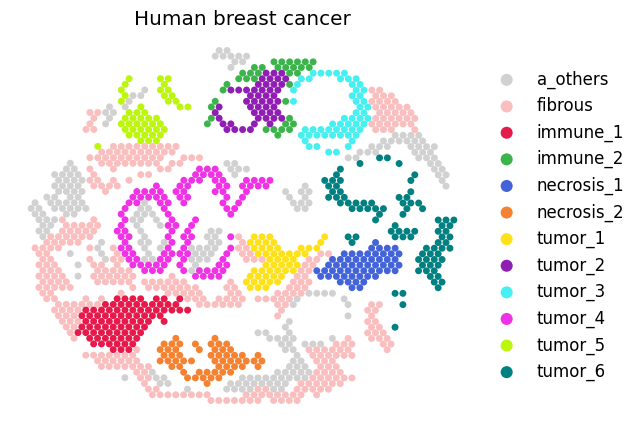

In [3]:
matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
sz = 100

plot_color=['#D1D1D1','#fabebe','#e6194b','#3cb44b', '#4363d8', '#f58231','#ffe119',  '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c',  '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
domains="cell_states"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Human breast cancer'
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
ax.axes.invert_yaxis()


## Calculating data distances and spatial distances

In [4]:
N = df_data.shape[0]
X = np.array(df_data)
dist_sq = euclidean_distances(X, X)
dist_sq = (dist_sq + dist_sq.T) / 2.0
dist_data = scipy.spatial.distance.squareform(dist_sq)
X_spa = np.array(df_pos)
dist_sq = euclidean_distances(X_spa,X_spa)
dist_sq = (dist_sq + dist_sq.T) / 2.0
dist_spatial = scipy.spatial.distance.squareform(dist_sq)

## Performing t-SNE embedding

(-27.944083520203527,
 26.384484151760166,
 -12.23222901421315,
 12.113360449979758)

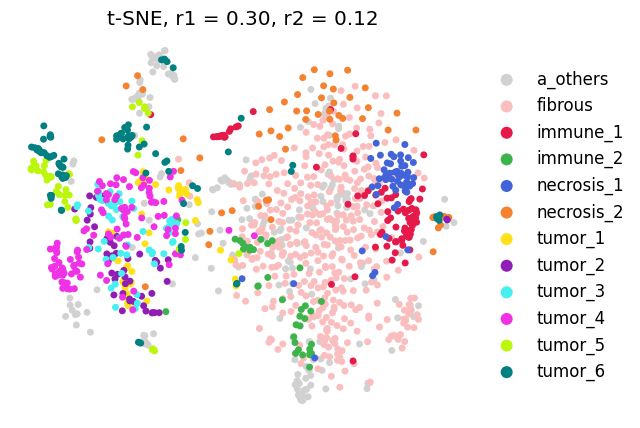

In [5]:
tsne_pos = spasne.run_spasne(df_data, alpha = 0.0, randseed = 1)
dist_sq = euclidean_distances(tsne_pos, tsne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
# Measuring gene expression preservation
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
# Measuring spatial structure preservation
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
# Calculating silhouette score based on annotation of subtypes
ss = sklearn.metrics.silhouette_score(tsne_pos,cluster_label_2)
quant_eval_tsne = [r1,r2,ss]
adata.obs['tsne_pos_x'] = tsne_pos[:,0]
adata.obs['tsne_pos_y'] = tsne_pos[:,1]

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
domains="cell_states"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
# titles = 't-SNE, ' + 'r1 = %.2f'% quant_eval_tsne[0] + ', r2 = %.2f'%quant_eval_tsne[1] + ', tw = %.2f'%quant_eval_tsne[3]
titles = 't-SNE, ' + 'r1 = %.2f'% quant_eval_tsne[0] + ', r2 = %.2f'%quant_eval_tsne[1] 
ax=sc.pl.scatter(adata,alpha=1,x="tsne_pos_x",y="tsne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')

## Performing SpaSNE embedding with balanced parameters

(-1.2914712095826015,
 1.4487787507577656,
 -1.3603204512366196,
 1.3710290438762842)

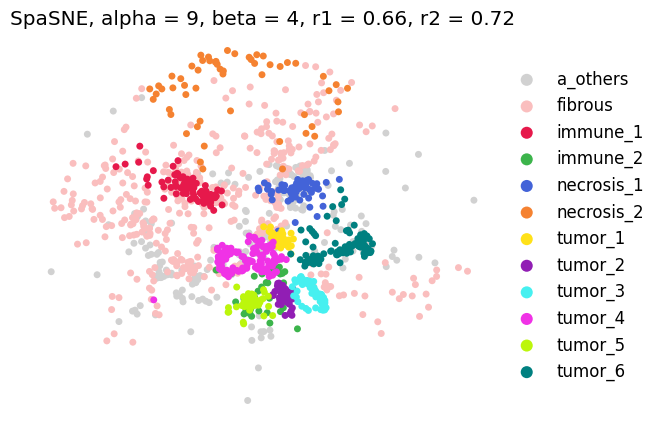

In [6]:
alpha = 9
beta = 4
spasne_pos = spasne.run_spasne(df_data, pixels = df_pos, alpha = alpha, beta = beta,randseed = 1)
dist_sq = euclidean_distances(spasne_pos, spasne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label_2)
quant_eval_spasne = [r1,r2,ss]

adata.obs['spasne_pos_x'] = spasne_pos[:,0]
adata.obs['spasne_pos_y'] = spasne_pos[:,1]

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
domains="cell_states"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'SpaSNE, '+'alpha = '+str(alpha)+ ', beta = '+str(beta) + ', r1 = %.2f'% quant_eval_spasne[0] + ', r2 = %.2f'%quant_eval_spasne[1] 

ax=sc.pl.scatter(adata,alpha=1,x="spasne_pos_x",y="spasne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')

## Emphasizing global structure of gene expression with larger alpha

(-1.5863507792613682,
 1.613714781872611,
 -1.061437833842999,
 1.4227728701144011)

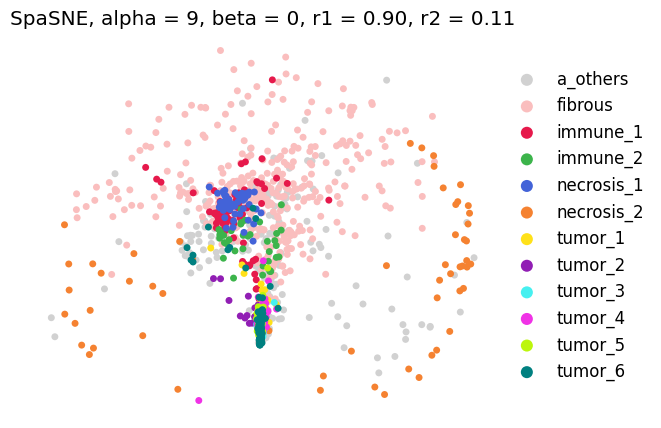

In [7]:
alpha = 9
beta = 0
spasne_pos = spasne.run_spasne(df_data, pixels = df_pos, alpha = alpha, beta = beta,randseed = 1)
dist_sq = euclidean_distances(spasne_pos, spasne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label_2)
quant_eval_spasne = [r1,r2,ss]

adata.obs['spasne_pos_x'] = spasne_pos[:,0]
adata.obs['spasne_pos_y'] = spasne_pos[:,1]

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
domains="cell_states"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'SpaSNE, '+'alpha = '+str(alpha)+ ', beta = '+str(beta) + ', r1 = %.2f'% quant_eval_spasne[0] + ', r2 = %.2f'%quant_eval_spasne[1] 

ax=sc.pl.scatter(adata,alpha=1,x="spasne_pos_x",y="spasne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')

## Emphasizing global structure of spatial expression with larger beta 

(-2.3715876128503868,
 2.3326177992398986,
 -2.3282042983963858,
 2.6776367811961967)

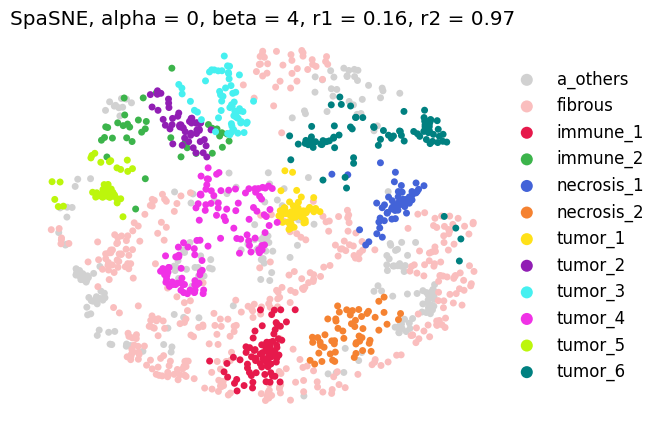

In [8]:
alpha = 0
beta = 4
spasne_pos = spasne.run_spasne(df_data, pixels = df_pos, alpha = alpha, beta = beta,randseed = 1)
dist_sq = euclidean_distances(spasne_pos, spasne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
ss = sklearn.metrics.silhouette_score(spasne_pos,cluster_label_2)
quant_eval_spasne = [r1,r2,ss]

adata.obs['spasne_pos_x'] = spasne_pos[:,0]
adata.obs['spasne_pos_y'] = spasne_pos[:,1]

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
domains="cell_states"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'SpaSNE, '+'alpha = '+str(alpha)+ ', beta = '+str(beta) + ', r1 = %.2f'% quant_eval_spasne[0] + ', r2 = %.2f'%quant_eval_spasne[1] 

ax=sc.pl.scatter(adata,alpha=1,x="spasne_pos_x",y="spasne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')